In [1]:
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from typing import Dict, List

In [2]:
experiments_dir = Path(os.getcwd())
directories = [dir_name for dir_name in os.listdir(experiments_dir) if os.path.isdir(dir_name)]

print(directories)

['I 250000 U 125000 S 100 Y 0.25 T 16 wc 0.25 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 5 wc 0.5 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 8 rq 0', 'I 250000 U 125000 S 100 Y 0.25 T 3 wc 1.0 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 4 wc 0.25 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 2 rq 0', 'I 250000 U 125000 S 100 Y 0.25 T 2 wc 0.5 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 10 rq 0', 'I 250000 U 125000 S 100 Y 0.25 T 5 rq 0', 'I 250000 U 125000 S 100 Y 0.25 T 10 wc 0.25 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 10 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 16 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 2 wc 1.0 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 4 wc 1.0 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 3 wc 0.25 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 16 wc 1.0 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 4 wc 0.5 utl 0.4 ltu 0.8 rq 1', 'I 25

In [3]:
def process_text_stats(stats_file) -> Dict[str, int]:
    stats_to_pull = [
        "rocksdb.compaction.key.drop.new",
        "rocksdb.number.db.seek",
        "rocksdb.number.db.next",
        "rocksdb.number.db.seek.found",
        "rocksdb.number.db.next.found",
        "rocksdb.db.iter.bytes.read",
        "rocksdb.no.file.opens",
        "rocksdb.compact.read.bytes",
        "rocksdb.compact.write.bytes",
        "rocksdb.flush.write.bytes",
        "rocksdb.read.amp.estimate.useful.bytes",
        "rocksdb.read.amp.total.read.bytes",
        "rocksdb.files.deleted.immediately",
        "rocksdb.memtable.payload.bytes.at.flush",
        "rocksdb.compaction.times.micros",
        "rocksdb.read.block.compaction.micros",
        "rocksdb.write.raw.block.micros",
        "rocksdb.numfiles.in.singlecompaction",
        "rocksdb.file.read.compaction.micros",
        "rocksdb.db.flush.micros",
    ]

    filtered_dictionary = dict()
    with open(stats_file, "r") as file:
        for line in file:
            found_stat = False
            for stat in stats_to_pull:
                if line.startswith(stat):
                    line = line.strip(" \n ")
                    parts = line.split(":")
                    if len(parts) == 2:
                        filtered_dictionary[stat] = parts[1].strip()
                        found_stat = True
                    else:
                        for index, part in enumerate(parts):
                            if "COUNT" in part:
                                filtered_dictionary[stat] = (
                                    parts[index + 1].strip().split(" ")[0].strip()
                                )
                                found_stat = True
                                break

                if found_stat:
                    break

    return filtered_dictionary

In [4]:
results = pd.DataFrame(
    columns=[
        'workload',
        'inserts', 
        'updates', 
        'deletes', 
        'rangeQueries', 
        'selectivity', 
        'sizeRatio', 
        'writeCost', 
        'upperToLowerRatio', 
        'lowerToUpperRatio', 
        'approach',
        'bytesWrittenInCompaction',
        'bytesWrittenInBufferWrites',
        'bytesWrittenInTotal',
        'writeAmp',
    ]
)

for directory in directories:
    directory_path = experiments_dir / directory
    _, inserts, _, updates, _, range_queries, _, selectivity, _, size_ratio, *args = directory.split(' ')
    approach = int(args.pop(-1))
    args.pop(-1)

    write_cost = float(args.pop(1)) if len(args) > 0 else 0
    args.pop(0) if len(args) > 0 else None
    upper_to_lower_ratio = float(args.pop(1)) if len(args) > 0 else 0
    args.pop(0) if len(args) > 0 else None
    lower_to_upper_ratio = float(args.pop(1)) if len(args) > 0 else float('inf')
    args.pop(0) if len(args) > 0 else None

    result_row = {
        'workload': directory,
        'inserts': int(inserts),
        'updates': int(updates),
        'deletes': 0,
        'rangeQueries': int(range_queries),
        'selectivity': float(selectivity),
        'sizeRatio': int(size_ratio),
        'writeCost': write_cost,
        'upperToLowerRatio': upper_to_lower_ratio,
        'lowerToUpperRatio': lower_to_upper_ratio,
        'approach': 'rqdc' if approach == 1 else 'vanilla',
        'bytesWrittenInCompaction': 0,
        'bytesWrittenInBufferWrites': 0,
        'bytesWrittenInTotal': 0,
        'writeAmp': 0,
    }

    for file in os.listdir(directory_path):
        if file.endswith('stats.txt'):
            file_path = directory_path / file
            stats = process_text_stats(file_path)
            result_row['bytesWrittenInCompaction'] = int(stats['rocksdb.compact.write.bytes'])
            result_row['bytesWrittenInBufferWrites'] = int(stats['rocksdb.flush.write.bytes'])
            result_row['bytesWrittenInTotal'] = int(stats['rocksdb.compact.write.bytes']) + int(stats['rocksdb.flush.write.bytes'])
            result_row['writeAmp'] = float(result_row['bytesWrittenInTotal'] / result_row['inserts'] * 1024)
            results = results.append(result_row, ignore_index=True)
            # print(result_row)

In [5]:
results.head()

,workload,inserts,updates,deletes,rangeQueries,selectivity,sizeRatio,writeCost,upperToLowerRatio,lowerToUpperRatio,approach,bytesWrittenInCompaction,bytesWrittenInBufferWrites,bytesWrittenInTotal,writeAmp
0,I 250000 U 125000 S 100 Y 0.25 T 16 wc 0.25 ut...,250000,125000,0,100,0.25,16,0.25,0.4,0.8,rqdc,3418916521,643864019,4062780540,1.664115e+07
1,I 250000 U 125000 S 100 Y 0.25 T 5 wc 0.5 utl ...,250000,125000,0,100,0.25,5,0.50,0.4,0.8,rqdc,2668103086,810172890,3478275976,1.424702e+07
2,I 250000 U 125000 S 100 Y 0.25 T 8 rq 0,250000,125000,0,100,0.25,8,0.00,0.0,inf,vanilla,3355283684,389776815,3745060499,1.533977e+07
3,I 250000 U 125000 S 100 Y 0.25 T 3 wc 1.0 utl ...,250000,125000,0,100,0.25,3,1.00,0.4,0.8,rqdc,3069337616,389764489,3459102105,1.416848e+07
4,I 250000 U 125000 S 100 Y 0.25 T 4 wc 0.25 utl...,250000,125000,0,100,0.25,4,0.25,0.4,0.8,rqdc,2746870641,758139352,3505009993,1.435652e+07


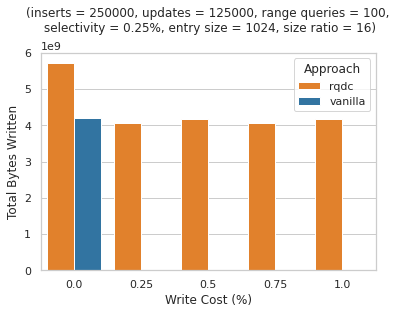

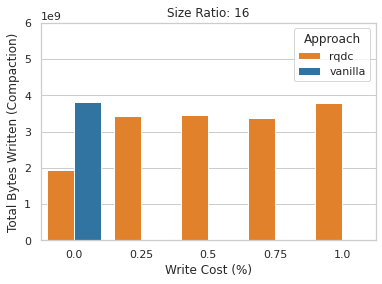

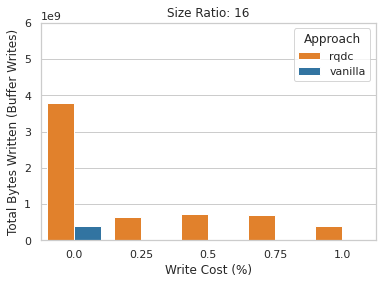

In [11]:
# size_ratios = [2, 3, 4, 5, 8, 10, 16]
size_ratios = [16]
custom_colors = {"vanilla": "#1f77b4", "rqdc": "#ff7f0e"}

for size_ratio in size_ratios:
    size_ratio_2_vs_write_cost_25_percent = results[results['sizeRatio'] == size_ratio]
    df = size_ratio_2_vs_write_cost_25_percent[['inserts', 'updates', 'rangeQueries', 'selectivity', 'writeCost', 'approach', 'bytesWrittenInTotal']]
    df = df.sort_values(by=['writeCost', 'approach'], ascending=False)

    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x="writeCost", y="bytesWrittenInTotal", hue="approach", data=df, palette=custom_colors)
    ax.title.set_text(f"(inserts = {df['inserts'].iloc[0]}, updates = {df['updates'].iloc[0]}, range queries = {df['rangeQueries'].iloc[0]},\n selectivity = {df['selectivity'].iloc[0]}%, entry size = 1024, size ratio = {size_ratio})\n")
    ax.set(xlabel='Write Cost (%)', ylabel='Total Bytes Written')

    max_y = 6000000000
    ax.set(ylim=(0, max_y))
    ax.legend(title="Approach", loc="upper right")
    plt.show()


# # size_ratios = [2, 3, 4, 5, 8, 10, 16]
# # custom_colors = {"vanilla": "#1f77b4", "rqdc": "#ff7f0e"}

for size_ratio in size_ratios:
    size_ratio_2_vs_write_cost_25_percent = results[results['sizeRatio'] == size_ratio]
    df = size_ratio_2_vs_write_cost_25_percent[['writeCost', 'approach', 'bytesWrittenInCompaction']]
    df = df.sort_values(by=['writeCost', 'approach'], ascending=False)

    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x="writeCost", y="bytesWrittenInCompaction", hue="approach", data=df, palette=custom_colors)
    ax.title.set_text(f"Size Ratio: {size_ratio}")
    ax.set(xlabel='Write Cost (%)', ylabel='Total Bytes Written (Compaction)')

    max_y = 6000000000
    ax.set(ylim=(0, max_y))
    ax.legend(title="Approach", loc="upper right")
    plt.show()

# # size_ratios = [2, 3, 4, 5, 8, 10, 16]
# # custom_colors = {"vanilla": "#1f77b4", "rqdc": "#ff7f0e"}

for size_ratio in size_ratios:
    size_ratio_2_vs_write_cost_25_percent = results[results['sizeRatio'] == size_ratio]
    df = size_ratio_2_vs_write_cost_25_percent[['writeCost', 'approach', 'bytesWrittenInBufferWrites']]
    df = df.sort_values(by=['writeCost', 'approach'], ascending=False)

    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x="writeCost", y="bytesWrittenInBufferWrites", hue="approach", data=df, palette=custom_colors)
    ax.title.set_text(f"Size Ratio: {size_ratio}")
    ax.set(xlabel='Write Cost (%)', ylabel='Total Bytes Written (Buffer Writes)')

    max_y = 6000000000
    ax.set(ylim=(0, max_y))
    ax.legend(title="Approach", loc="upper right")
    plt.show()

# size_ratios = [2, 3, 4, 5, 8, 10, 16]
# custom_colors = {"vanilla": "#1f77b4", "rqdc": "#ff7f0e"}

# for size_ratio in size_ratios:
#     size_ratio_2_vs_write_cost_25_percent = results[results['sizeRatio'] == size_ratio]
#     df = size_ratio_2_vs_write_cost_25_percent[['writeCost', 'approach', 'writeAmp']]
#     df = df.sort_values(by=['writeCost', 'approach'], ascending=False)

#     sns.set_theme(style="whitegrid")
#     ax = sns.lineplot(x="writeCost", y="writeAmp", hue="approach", data=df, palette=custom_colors)
#     ax.title.set_text(f"Size Ratio: {size_ratio}")
#     ax.set(xlabel='Write Cost (%)', ylabel='Total Bytes Written (Buffer Writes)')

#     # Uncomment the following lines if you want to set a specific y-axis limit:
#     # max_y = 6000000000
#     # ax.set(ylim=(0, max_y))

#     ax.legend(title="Approach", loc="upper right")
#     plt.show()

In [7]:
expected_files = [
    "rqc_off_stats.csv",
    "rqc_on_stats.csv",
    "rqc_off_stats.txt",
    "rqc_on_stats.txt",
]
columns_in_csv = [
    "Query No",
    "Query Type",
    "Key",
    "Levels Before",
    "Levels After",
    "Files Before",
    "Files After",
    "Entries Before",
    "Entries After",
    "Time Taken",
]


def each_query_stats_comparison(off_stats_df, on_stats_df, dir_name):
    # number of levels before and after query
    level_df = pd.merge(
        off_stats_df[["Query No", "Levels After"]],
        on_stats_df[["Query No", "Levels After"]],
        on="Query No",
    )
    level_df = level_df.rename(
        columns={
            "Levels After_x": "Vanilla # of Levels After",
            "Levels After_y": "RQC # of Levels After",
        }
    )
    new_df = level_df.tail(1)
    plt.bar(["Vanilla", "RQC"], [new_df["Vanilla # of Levels After"].iloc[0], new_df["RQC # of Levels After"].iloc[0]], color=["b", "r"])
    # new_df.plot(
    #     x="Query No", y=["Vanilla # of Levels After", "RQC # of Levels After"], kind="bar"
    # )
    plt.ylabel("# of levels during each query")
    plt.title(dir_name)
    # plt.show()
    plt.savefig(f'levels_comparison.png')  # Save each graph as a separate image
    plt.close()
    # level_df = pd.merge(off_stats_df[["Query No", "Levels Before", "Levels After"]], on_stats_df[["Query No", "Levels Before", "Levels After"]], on="Query No")
    # level_df = level_df.rename(columns={"Levels Before_x": "Vanilla # of Levels Before", "Levels After_x": "Vanilla # of Levels After", "Levels Before_y": "RQC # of Levels Before", "Levels After_y": "RQC # of Levels After"})
    # level_df.plot(x="Query No", y=["Vanilla # of Levels Before", "Vanilla # of Levels After", "RQC # of Levels Before", "RQC # of Levels After"])
    # plt.xlabel("Query Number")
    # plt.ylabel("# of levels during each query")
    # plt.title(dir_name)
    # plt.show()

    # number of files before after query
    files_df = pd.merge(
        off_stats_df[["Query No", "Files After"]],
        on_stats_df[["Query No", "Files After"]],
        on="Query No",
    )
    files_df = files_df.rename(
        columns={
            "Files After_x": "Vanilla # of Files After",
            "Files After_y": "RQC # of Files After",
        }
    )
    new_df = files_df.tail(1)
    plt.bar(["Vanilla", "RQC"], [new_df["Vanilla # of Files After"].iloc[0], new_df["RQC # of Files After"].iloc[0]], color=["b", "r"])
    # files_df.plot(x="Query No", y=["Vanilla # of Files After", "RQC # of Files After"])
    plt.ylabel("# of files during each query")
    plt.title(dir_name)
    # plt.show()
    plt.savefig(f'files_comparison.png')  # Save each graph as a separate image
    plt.close()    
    # files_df = pd.merge(off_stats_df[["Query No", "Files Before", "Files After"]], on_stats_df[["Query No", "Files Before", "Files After"]], on="Query No")
    # files_df = files_df.rename(columns={"Files Before_x": "Vanilla # of Files Before", "Files After_x": "Vanilla # of Files After", "Files Before_y": "RQC # of Files Before", "Files After_y": "RQC # of Files After"})
    # files_df.plot(x="Query No", y=["Vanilla # of Files Before", "Vanilla # of Files After", "RQC # of Files Before", "RQC # of Files After"])
    # plt.xlabel("Query Number")
    # plt.ylabel("# of files during each query")
    # plt.title(dir_name)
    # plt.show()

    # number of entries before after query
    files_df = pd.merge(
        off_stats_df[["Query No", "Entries After"]],
        on_stats_df[["Query No", "Entries After"]],
        on="Query No",
    )
    files_df = files_df.rename(
        columns={
            "Entries After_x": "Vanilla # of Entries After",
            "Entries After_y": "RQC # of Entries After",
        }
    )
    new_df = files_df.tail(1)
    plt.bar(["Vanilla", "RQC"], [new_df["Vanilla # of Entries After"].iloc[0], new_df["RQC # of Entries After"].iloc[0]], color=["b", "r"])
    # files_df.plot(
    #     x="Query No", y=["Vanilla # of Entries After", "RQC # of Entries After"]
    # )
    plt.ylabel("# of entries during each query")
    plt.title(dir_name)
    # plt.show()
    plt.savefig(f'entries_comparison.png')  # Save each graph as a separate image
    plt.close()    
    # files_df = pd.merge(off_stats_df[["Query No", "Entries Before", "Entries After"]], on_stats_df[["Query No", "Entries Before", "Entries After"]], on="Query No")
    # files_df = files_df.rename(columns={"Entries Before_x": "Vanilla # of Entries Before", "Entries After_x": "Vanilla # of Entries After", "Entries Before_y": "RQC # of Entries Before", "Entries After_y": "RQC # of Entries After"})
    # files_df.plot(x="Query No", y=["Vanilla # of Entries Before", "Vanilla # of Entries After", "RQC # of Entries Before", "RQC # of Entries After"])
    # plt.xlabel("Query Number")
    # plt.ylabel("# of entries during each query")
    # plt.title(dir_name)
    # plt.show()

    # time taken by each query
    files_df = pd.merge(
        off_stats_df[["Query No", "Time Taken"]],
        on_stats_df[["Query No", "Time Taken"]],
        on="Query No",
    )
    files_df = files_df.rename(
        columns={"Time Taken_x": "Vanilla Time Taken", "Time Taken_y": "RQC Time Taken"}
    )
    files_df.plot(x="Query No", y=["Vanilla Time Taken", "RQC Time Taken"])
    plt.ylabel("time taken by each query")
    plt.title(dir_name)
    # plt.show()
    plt.savefig(f'time_taken_comparison.png')  # Save each graph as a separate image
    plt.close()
    # files_df = pd.merge(off_stats_df[["Query No", "Time Taken"]], on_stats_df[["Query No", "Time Taken"]], on="Query No")
    # files_df = files_df.rename(columns={"Time Taken_x": "Vanilla Time Taken", "Time Taken_y": "RQC Time Taken"})
    # files_df.plot(x="Query No", y=["Vanilla Time Taken", "RQC Time Taken"])
    # plt.xlabel("Query Number")
    # plt.ylabel("time taken by each query")
    # plt.title(dir_name)
    # plt.show()


def process_text_stats(stats_file) -> Dict[str, int]:
    stats_to_pull = [
        "rocksdb.compaction.key.drop.new",
        "rocksdb.number.db.seek",
        "rocksdb.number.db.next",
        "rocksdb.number.db.seek.found",
        "rocksdb.number.db.next.found",
        "rocksdb.db.iter.bytes.read",
        "rocksdb.no.file.opens",
        "rocksdb.compact.read.bytes",
        "rocksdb.compact.write.bytes",
        "rocksdb.flush.write.bytes",
        "rocksdb.read.amp.estimate.useful.bytes",
        "rocksdb.read.amp.total.read.bytes",
        "rocksdb.files.deleted.immediately",
        "rocksdb.memtable.payload.bytes.at.flush",
        "rocksdb.compaction.times.micros",
        "rocksdb.read.block.compaction.micros",
        "rocksdb.write.raw.block.micros",
        "rocksdb.numfiles.in.singlecompaction",
        "rocksdb.file.read.compaction.micros",
        "rocksdb.db.flush.micros",
    ]

    filtered_dictionary = dict()
    with open(stats_file, "r") as file:
        for line in file:
            found_stat = False
            for stat in stats_to_pull:
                if line.startswith(stat):
                    line = line.strip(" \n ")
                    parts = line.split(":")
                    if len(parts) == 2:
                        filtered_dictionary[stat] = parts[1].strip()
                        found_stat = True
                    else:
                        for index, part in enumerate(parts):
                            if "COUNT" in part:
                                filtered_dictionary[stat] = (
                                    parts[index + 1].strip().split(" ")[0].strip()
                                )
                                found_stat = True
                                break

                if found_stat:
                    break

    return filtered_dictionary


all_stats = dict()

def generate_graph_for_experiment(dir_name):
    assert len(expected_files) == 4

    for expected_file in expected_files:
        if not os.path.exists(expected_file):
            print("Expected File ", expected_file, " NOT FOUND!")
            return

    off_stats_csv = expected_files[0]
    on_stats_csv = expected_files[1]
    off_stats_txt = expected_files[2]
    on_stats_txt = expected_files[3]

    off_stats_frame = pd.read_csv(off_stats_csv, names=columns_in_csv)
    on_stats_frame = pd.read_csv(on_stats_csv, names=columns_in_csv)

    # each_query_stats_comparison(off_stats_frame, on_stats_frame, dir_name)

    off_stats_dict = process_text_stats(off_stats_txt)
    on_stats_dict = process_text_stats(on_stats_txt)

    all_stats[dir_name] = {"Vanilla": off_stats_dict}
    all_stats[dir_name]["RQC"] = on_stats_dict

    # for key in off_stats_dict.keys():
    #     value1 = int(off_stats_dict[key])
    #     value2 = int(on_stats_dict[key])

    #     plt.figure(figsize=(6, 4))
    #     plt.bar(["Vanilla", "RQC"], [value1, value2], color=["b", "r"])
    #     plt.ylabel("Values")
    #     plt.title(f"Comparison for Parameter: {key}")
    #     plt.tight_layout()

    #     plt.savefig(f"{key}_comparison.png")  # Save each graph as a separate image
    #     plt.close()
    
    # difference = list()
    # last = None

    # def get_line(f):
    #     while line:=f.readline():
    #         yield line

    # f = open('workload.txt', 'r')

    # for index, line in enumerate(get_line(f), 1):
    #     if line.startswith('S '):
    #         if last == None:
    #             last = index
    #         else:
    #             difference.append(index - last)
    #             last = index

    # x = range(len(difference))
    # plt.bar(x, difference)
    # plt.title(dir_name)
    # plt.savefig("rqintervals.png")
    # plt.close()
    

In [8]:
for directory in directories:
    assert os.path.exists(directory)
    os.chdir(directory)
    generate_graph_for_experiment(directory)
    os.chdir("../")

Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_on_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_on_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_on_stats.csv  NOT FOUND!
Expected File  rqc_on_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_on_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_off_stats.csv  NOT FOUND!
Expected File  rqc_on_stats.csv  NOT FOUND!
Expected File  r

In [9]:
whole_data = []

for dirname in all_stats.keys():
    if not dirname.startswith("I 1000000"):
        _, inserts, _, updates, _, rangeq, _, selectivity, _, size_ratio, *something = dirname.split(' ')
        for approach in all_stats[dirname]:
            whole_data.append([
                int(inserts), int(updates), int(rangeq), float(selectivity), approach, 
                int(all_stats[dirname][approach]['rocksdb.compact.read.bytes']),
                int(all_stats[dirname][approach]['rocksdb.compact.write.bytes']),
                int(all_stats[dirname][approach]['rocksdb.compaction.key.drop.new']),
                int(all_stats[dirname][approach]['rocksdb.compaction.times.micros']),
                int(all_stats[dirname][approach]['rocksdb.db.flush.micros']),
                int(all_stats[dirname][approach]['rocksdb.db.iter.bytes.read']),
                int(all_stats[dirname][approach]['rocksdb.file.read.compaction.micros']),
                int(all_stats[dirname][approach]['rocksdb.files.deleted.immediately']),
                int(all_stats[dirname][approach]['rocksdb.flush.write.bytes']),
                int(all_stats[dirname][approach]['rocksdb.memtable.payload.bytes.at.flush']),
                int(all_stats[dirname][approach]['rocksdb.no.file.opens']),
                int(all_stats[dirname][approach]['rocksdb.number.db.next']),
                int(all_stats[dirname][approach]['rocksdb.number.db.seek']),
                int(all_stats[dirname][approach]['rocksdb.numfiles.in.singlecompaction']),
                int(all_stats[dirname][approach]['rocksdb.read.amp.estimate.useful.bytes']),
                int(all_stats[dirname][approach]['rocksdb.read.amp.total.read.bytes']),
                int(all_stats[dirname][approach]['rocksdb.read.block.compaction.micros']),
                int(all_stats[dirname][approach]['rocksdb.write.raw.block.micros']),
            ])

In [10]:
columns = ["Inserts", "Updates", "Range", "Selectivity", "Approach", "rocksdb.compact.read.bytes", "rocksdb.compact.write.bytes", "rocksdb.compaction.key.drop.new",
           "rocksdb.compaction.times.micros", "rocksdb.db.flush.micros", "rocksdb.db.iter.bytes.read", "rocksdb.file.read.compaction.micros",
           "rocksdb.files.deleted.immediately", "rocksdb.flush.write.bytes", "rocksdb.memtable.payload.bytes.at.flush", "rocksdb.no.file.opens",
           "rocksdb.number.db.next", "rocksdb.number.db.seek", "rocksdb.numfiles.in.singlecompaction", "rocksdb.read.amp.estimate.useful.bytes",
           "rocksdb.read.amp.total.read.bytes", "rocksdb.read.block.compaction.micros", "rocksdb.write.raw.block.micros"]

df = pd.DataFrame(whole_data, columns=columns)


time_related_columns = ["rocksdb.compaction.times.micros", "rocksdb.db.flush.micros"]

byte_related_columns = ["rocksdb.compact.read.bytes", "rocksdb.compact.write.bytes", "rocksdb.flush.write.bytes"]

count_related_columns = ["rocksdb.numfiles.in.singlecompaction", "rocksdb.files.deleted.immediately", "rocksdb.compaction.key.drop.new"]

# for col in time_related_columns:
#     plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
#     ax = sns.barplot(x="Selectivity", y=col, hue="Approach", data=df)
#     plt.title(col)
#     plt.xlabel("Selectivity")
#     plt.ylabel(col)
#     plt.legend(loc="best")
    
#     plt.tight_layout()
#     plt.show()


for col in byte_related_columns:
    plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
    ax = sns.barplot(x="Selectivity", y=col, hue="Approach", data=df)
    plt.title(col)
    plt.xlabel("Selectivity")
    plt.ylabel(col)
    plt.legend(loc="best")
    
    plt.tight_layout()
    plt.show()


# for col in count_related_columns:
#     plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
#     ax = sns.barplot(x="Selectivity", y=col, hue="Approach", data=df)
#     plt.title(col)
#     plt.xlabel("Selectivity")
#     plt.ylabel(col)
#     plt.legend(loc="best")
    
#     plt.tight_layout()
#     plt.show()

# for col in time_taken_columns:
#     plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
#     ax = sns.barplot(x="Selectivity", y=col, hue="Approach", data=df)
#     plt.title(col)
#     plt.xlabel("Selectivity")
#     plt.ylabel(col)
#     plt.legend(loc="best")
    
#     plt.tight_layout()
#     plt.show()


ValueError: min() arg is an empty sequence

<Figure size 576x360 with 0 Axes>